In [ ]:
# Kütüphaneler ve Sabitler
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import copy
import time
import warnings

# Gereksiz uyarıları kapat
warnings.filterwarnings("ignore")

# --- AYARLAR ---
VERI_YOLU = "D:\hamza\derin_ogrenme_proje\2012-09-12"  
NUM_FOLDS = 5        
NUM_EPOCHS = 5       
BATCH_SIZE = 32
LEARNING_RATE = 0.001
SEED = 42            

# Seed sabitleme
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

seed_everything(SEED)

# --- DONANIM SEÇİMİ ---
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print(f"✅ [SİSTEM] Apple Silicon GPU Aktif.")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"✅ [SİSTEM] NVIDIA CUDA GPU Aktif.")
else:
    DEVICE = torch.device("cpu")
    print(f"⚠️ [SİSTEM] GPU Bulunamadı. İşlemci (CPU) kullanılıyor.")

✅ [SİSTEM] NVIDIA CUDA GPU Aktif.


📊 Sınıf Dağılımı: {'Empty': 14032, 'Occupied': 18295}


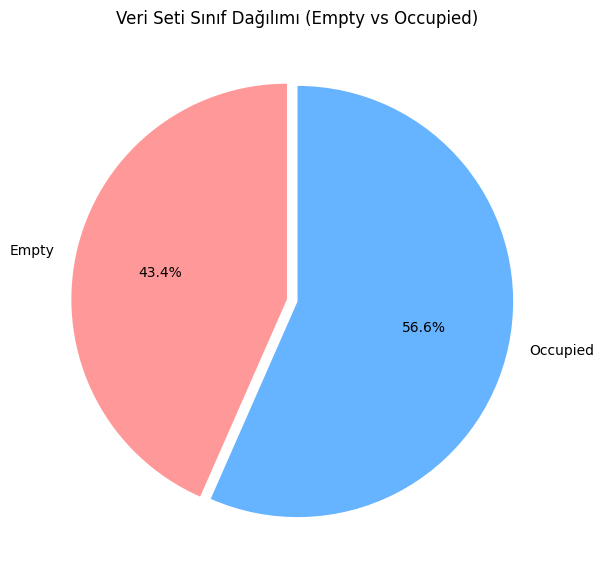

In [7]:
# Veri Analizi ve Sınıf Dağılımı
if not os.path.exists(VERI_YOLU):
    raise FileNotFoundError(f"HATA: Klasör bulunamadı: {VERI_YOLU}")

# Veri seti yükle
temp_dataset = datasets.ImageFolder(VERI_YOLU)
classes = temp_dataset.classes
targets = temp_dataset.targets

class_counts = {classname: targets.count(i) for i, classname in enumerate(classes)}
print(f"📊 Sınıf Dağılımı: {class_counts}")

# Pasta Grafiği
plt.figure(figsize=(7, 7))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', 
        colors=['#ff9999','#66b3ff'], startangle=90, explode=(0.05, 0))
plt.title('Veri Seti Sınıf Dağılımı (Empty vs Occupied)')
plt.savefig('Dataset_PieChart.png') # Rapor için kaydet
plt.show()

In [8]:
# Dönüşümler ve Dataset Wrapper
# Bu sınıf, K-Fold sırasında Train ve Val verilerine farklı transform uygulamamızı sağlar.
class MapDataset(Dataset):
    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  
        y = self.dataset[index][1]   
        return x, y

    def __len__(self):
        return len(self.dataset)

# Transformlar
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
# VGG16 Model Tanımlama
def get_vgg16_model():
    model = models.vgg16(weights='DEFAULT')
    
    # Parametreleri dondur (Feature Extraction) - İsteğe bağlı, fine-tuning için açılabilir
    for param in model.parameters():
        param.requires_grad = False
    
    # Sınıflandırıcı katmanını değiştir
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
        nn.Linear(num_ftrs, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 2) # Binary Classification
    )
    return model.to(DEVICE)


🚀 VGG16 HIZLI EĞİTİM BAŞLIYOR (%80 Train - %20 Val)
Eğitim Verisi: 25861 | Test Verisi: 6466
Epoch 1/5 | Train Loss: 0.0961 Acc: 0.9643 | Val Loss: 0.0805 Acc: 0.9695
Epoch 2/5 | Train Loss: 0.0651 Acc: 0.9761 | Val Loss: 0.0511 Acc: 0.9861
Epoch 3/5 | Train Loss: 0.0604 Acc: 0.9792 | Val Loss: 0.0804 Acc: 0.9797
Epoch 4/5 | Train Loss: 0.0546 Acc: 0.9806 | Val Loss: 0.0541 Acc: 0.9835
Epoch 5/5 | Train Loss: 0.0542 Acc: 0.9808 | Val Loss: 0.0259 Acc: 0.9910

✅ Eğitim Tamamlandı! Süre: 20dk 37sn
Best Val Acc: 0.9910


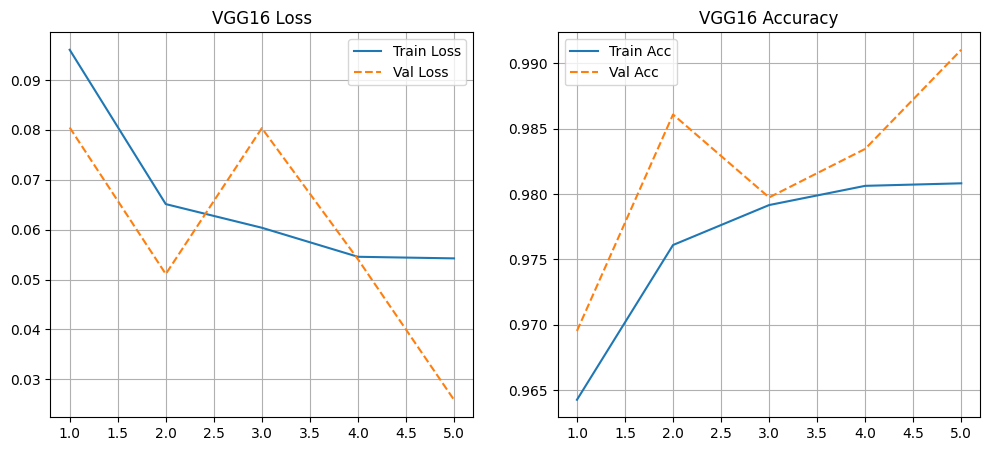

In [ ]:
# VGG16 İçin EĞİTİM (Standart %80-%20 Split)
from sklearn.model_selection import train_test_split
import copy
import time

# --- AYARLAR ---
VAL_SPLIT_RATIO = 0.20  # Verinin %20'si test, %80'i eğitim
NUM_EPOCHS = 5          

# Veri Setini Yükle
base_dataset = datasets.ImageFolder(VERI_YOLU)
targets_np = np.array(base_dataset.targets)

# Stratified Split (Sınıf dengesini koruyarak tek seferde ayır)
train_idx, val_idx = train_test_split(
    np.arange(len(targets_np)),
    test_size=VAL_SPLIT_RATIO,
    shuffle=True,
    stratify=targets_np,
    random_state=SEED
)

print(f"\n🚀 VGG16 HIZLI EĞİTİM BAŞLIYOR (%80 Train - %20 Val)")
print(f"Eğitim Verisi: {len(train_idx)} | Test Verisi: {len(val_idx)}")
print("="*60)

# Veri Yükleyicileri (Loaders)
train_sub = torch.utils.data.Subset(base_dataset, train_idx)
val_sub = torch.utils.data.Subset(base_dataset, val_idx)

train_data = MapDataset(train_sub, train_transforms)
val_data = MapDataset(val_sub, val_transforms)

# num_workers=0 (Hata riskini azaltır)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Model ve Optimizer
model = get_vgg16_model()
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

# Değişkenler
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
start_time = time.time()

# --- EĞİTİM DÖNGÜSÜ ---
for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    running_loss, correct_train = 0.0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels.data)
        
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train.float() / len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss_running, correct_val = 0.0, 0
    val_preds, val_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss_running += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += torch.sum(preds == labels.data)
            
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    epoch_val_loss = val_loss_running / len(val_loader.dataset)
    epoch_val_acc = correct_val.float() / len(val_loader.dataset)
    
    # Kayıt
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc.item())
    val_accs.append(epoch_val_acc.item())
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    # En iyi modeli tut
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

# Bitiş
time_elapsed = time.time() - start_time
print(f'\n✅ Eğitim Tamamlandı! Süre: {time_elapsed // 60:.0f}dk {time_elapsed % 60:.0f}sn')
print(f'Best Val Acc: {best_acc:.4f}')

# Grafik Çiz ve Kaydet
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label='Val Loss', linestyle='--')
plt.title('VGG16 Loss')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS+1), train_accs, label='Train Acc')
plt.plot(range(1, NUM_EPOCHS+1), val_accs, label='Val Acc', linestyle='--')
plt.title('VGG16 Accuracy')
plt.legend(); plt.grid(True)

plt.savefig('VGG16_Egitim_Grafigi.png')
plt.show()

# En iyi modeli kaydet
final_model = get_vgg16_model()
final_model.load_state_dict(best_model_wts)
torch.save(final_model.state_dict(), "FET312_VGG16_BestModel.pth")

# Sonuçları global değişkene at (Sonraki hücreler için)
last_fold_data = {
    'labels': val_labels,
    'preds': val_preds,
    'loader': val_loader
}


🏆 VGG16 PERFORMANS TABLOSU
                    Model  Accuracy  F1-Score  Precision  Recall
0  VGG16 (Standart Split)     0.991     0.991     0.9911   0.991


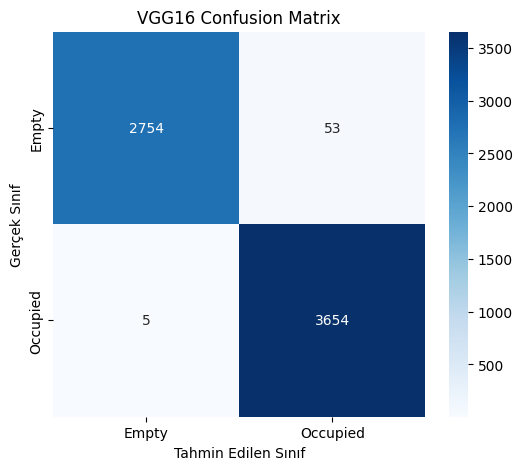

In [ ]:
# Sonuç Raporlama 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


labels = last_fold_data['labels']
preds = last_fold_data['preds']

# Metrikleri Hesapla
acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted')
prec = precision_score(labels, preds, average='weighted')
rec = recall_score(labels, preds, average='weighted')

# Tablo Oluştur (Tek Satır)
df_final = pd.DataFrame([{
    'Model': 'VGG16 (Standart Split)',
    'Accuracy': acc,
    'F1-Score': f1,
    'Precision': prec,
    'Recall': rec
}])

print("\n🏆 VGG16 PERFORMANS TABLOSU")
print("="*60)
print(df_final.round(4))
print("="*60)

# CSV Olarak Kaydet
df_final.to_csv("VGG16_Performans_Tablosu.csv")

# Confusion Matrix Çiz
plt.figure(figsize=(6, 5))
cm = confusion_matrix(labels, preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('VGG16 Confusion Matrix')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.savefig('VGG16_Confusion_Matrix.png')
plt.show()


[SİSTEM] Tahminler oluşturuluyor...


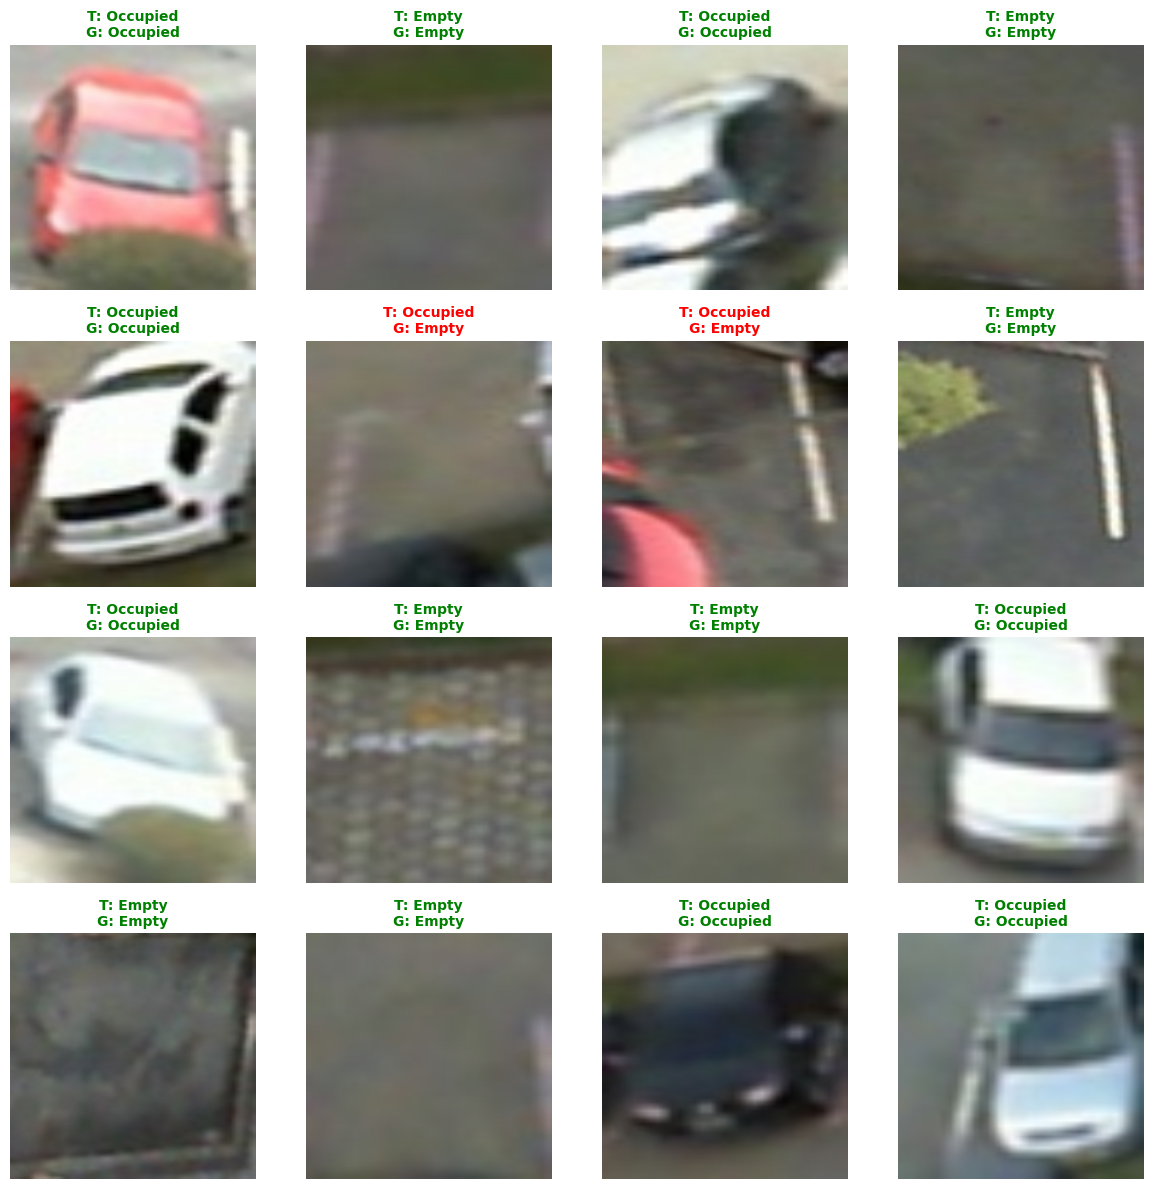

✅ Tahmin görseli 'VGG16_Ornek_Tahminler.png' olarak kaydedildi.


In [ ]:
# Tahmin Görselleştirme (VGG16)
import numpy as np

def visualize_single_batch(model, loader):
    model.eval()
    
    # Loader'dan bir batch veri çek
    iterator = iter(loader)
    images, labels = next(iterator)
    images = images.to(DEVICE)
    
    print(f"\n[SİSTEM] Tahminler oluşturuluyor...")
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
    plt.figure(figsize=(12, 12))
    
    # İlk 16 resmi göster
    for j in range(min(16, len(images))):
        ax = plt.subplot(4, 4, j + 1)
        
        # Görüntüyü normalize halden kurtar
        img = images[j].cpu().permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        
        
        if preds[j] == labels[j]:
            color = 'green'
        else:
            color = 'red'
            
        title_text = f"T: {classes[preds[j]]}\nG: {classes[labels[j]]}"
        ax.set_title(title_text, color=color, fontsize=10, fontweight='bold')
        plt.axis('off')
    
    plt.tight_layout()
    
    
    filename = 'VGG16_Ornek_Tahminler.png'
    plt.savefig(filename)
    plt.show()
    print(f"✅ Tahmin görseli '{filename}' olarak kaydedildi.")

# Fonksiyonu çalıştır - 'last_fold_data' kullanıyoruz
visualize_single_batch(final_model, last_fold_data['loader'])